In [1]:
import numpy as np

import gtsam
from gtsam.symbol_shorthand import B, V, X, L

from isam2_graph import ISAM2Graph
from gen_observations import *
from utils import *
from plot_trajectory import plot_trajectory

## Factor Graph Implementation and Inference using iSAM2 for solving the SLAM problem 

The SLAM problem consists of estimating $p(x_{0:T},\, b_{0:T},\, l_{1:N} \mid \mathbf{y})$, where $x_{0:T}$ is the state of the vehicle consisting of 3D position, 3D rotation and 3D velocity, $l_{1:N}$ is the position of the $N$ objects (landmarks) and $b_{0:T}$ is the bias of the IMU. 

The observations $\mathbf{y} = \{\mathbf{o}, \mathbf{z}, \mathbf{u}\}$ consists of  of IMU (i.e. acceleration and angular velocity) measurements $\mathbf{o}$, range-bearing detections of landmarks $\mathbf{z}$ and USBL position updates $\mathbf{u}$.

Recursivly, applying Bayes rule we obtain:

\begin{align*}
p(&x_{0:T},\, b_{0:T},\, l_{1:N} \mid \mathbf{y}) 
= \\ &\alpha\, p(x_0)\, p(b_0) \notag \\
 &\cdot \prod_{t=1}^{T} \Big[\, p(o_t \mid x_{t-1}, x_t, b_{t-1})\, p(b_t \mid b_{t-1}) \notag \\
&\qquad\ \cdot \prod_{z_{t,i} \in \mathbf{z}_t} p(z_{t,i} \mid x_t, l_i) \,\Big] \notag \\
&\cdot \prod_{u_t \in \mathbf{u}} p(u_t \mid x_t) \notag
\end{align*}

where each factor in the product is normally distributed, as standard in SLAM. $z_{t,i}$ is the observation of landmark $i$ from pose $x_t$, and $\alpha$ is the normalization constant.

This posterior distribution can be written as factor graph optimization problem, where  $\Theta = (\mathbf{x}, \mathbf{l}, \mathbf{b})$:
\begin{align*}
    f(\Theta) = \prod_i f_i(\Theta_i)
\end{align*}

The goal is to find:
\begin{align*}
    \Theta^* = \arg \max_\Theta f(\Theta)
\end{align*}
which corresponds to maximum likelihood estimation. 

ISAM2 can find this distribution by solving the underlying least-squares problem. By re-estimation the linearizaton (for non-linear factors such as IMUFactors and BearingRangeFactors) only when nescessary and creating a Bayes tree.



In [2]:
# Load an example dataset generated by HoloOcean
d = np.load("holoocean_scenarios/data/example.npz")
imu_noisy = d["imu"]
poses = d["poses"]
# remove gravity from IMU data for simplicity
imu_noisy[:,0] = remove_gravity(imu_noisy[:,0], poses, g=-9.8)

dt = 1/60 # specified by the holoocean environment
T = len(imu_noisy)//60

In [3]:
# create some artifical landmarks
landmarks = np.array([
    [5., 0, -12],
    [-10, -20, -12.2],
    [0, -25, -12]
])

# generate landmark observations and USBL pings
landmark_observations = generate_landmark_observations(poses[::60], landmarks, fov_h=(-60, 60), fov_v=(-10, 60),
                                                       bearing_noise=2, range_noise=1, seed=2)
# this creates a usbl observation every 20 seconds 
usbl_data = generate_usbl_data(poses[::60,:3,3], noise_std=0.25, rate=20)

In [4]:
# intialize the factor graph
# the prior pose is the first pose in the dataset, the bias is initialized to zero
# the prior velocity is set to zero, and the prior std is set to 0.1, the prior velocity std is set to 0.01
# the bias and noise is specified according the holoocean environment
# the gravity g is set to 0 (removed from IMU data beforehand)
isam2graph = ISAM2Graph(prior_pose=poses[0],
                        bias=gtsam.imuBias.ConstantBias(np.zeros(3), np.zeros(3)),
                        prior_vel=np.zeros(3),
                        prior_std=0.1,
                        prior_v_std=0.01,
                        bias_cov=np.array([0.00082,0.00082,0.00082,4.85e-5,4.85e-5,4.85e-5]),
                        g=0,
                        accel_var=0.023**2 * dt, gyro_var=0.00674**2 * dt) # continuous standard deviation, check https://borglab.github.io/gtsam/preintegrationparams

# Inference loop 

i = 0
for t in range(1, len(imu_noisy)):
    # preintegrate the IMU data
    isam2graph.preintegrate_imu(imu_noisy[t,0], imu_noisy[t,1], dt)
    if ((t % int(1/dt)) == 0) and (t>1):
        # after every second, add a new imu factor 
        # which accumulated one second of IMU data
        # creating a constraint between the previous pose and the current pose
        isam2graph.add_imu_factor()
        i += 1
        if i in landmark_observations.keys():
            for li in landmark_observations[i].keys():
                # add landmark observations to the graph
                isam2graph.add_landmark_obs(li, landmark_observations[i][li][0], landmark_observations[i][li][1],
                                            1, 0.5)
        if i in usbl_data.keys():
            # add usbl observations to the graph
            isam2graph.add_usbl_obs(usbl_data[i], 0.25)
        
        if (i % 5) == 0:
            # every 5 seconds, add create a new bias 
            # allowing the bias to change
            isam2graph.advance_bias(bias_noise=1e-3)
        # update the factor graph
        # this will also perform the optimization step
        isam2graph.update()

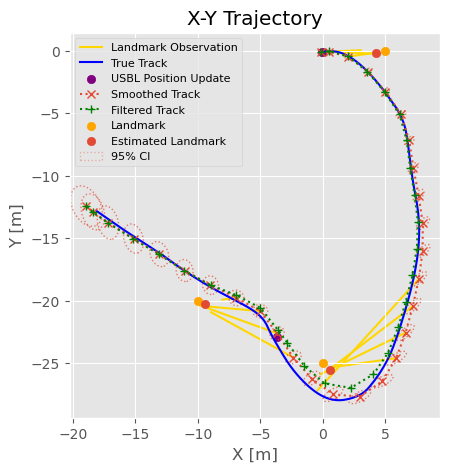

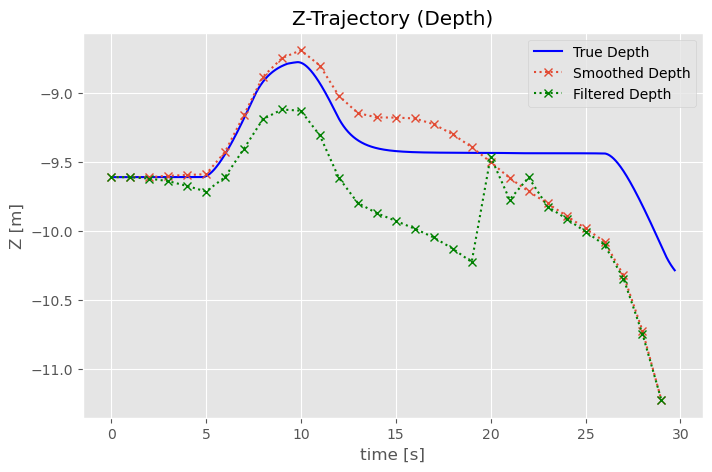

In [5]:
plot_trajectory(isam2graph, landmark_observations, usbl_data, poses, landmarks, dt)

In [6]:
# Retrieving the estimates
# (parameters of the posterior joint normal distribution)
smooth_trajectory = isam2graph.x_smooth
filter_trajectory = isam2graph.x_filter
smooth_rotations = isam2graph.r_smooth
filter_rotations = isam2graph.r_filter
landmark_estimates = isam2graph.landmark_positions
# work around to get the joint posterior 
linear_graph = isam2graph.isam.getFactorsUnsafe().linearize(isam2graph.current_estimate)
info_matrix = linear_graph.hessian()[0]
cov_matrix = np.linalg.inv(info_matrix)
# mariginal covariance
cov_x0 = isam2graph.isam.marginalCovariance(X(0))